In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-20T11:51:48.527952+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

sklearn   : 0.24.2
pandas    : 0.25.3
numpy     : 1.20.3
matplotlib: 3.3.4
seaborn   : 0.11.1



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 24
NAME = f'{NTRY}_cb_pca64_sber_bord_nose_iter_poly'

In [9]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [10]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [11]:
df_train.shape, df_test.shape, 

((6981, 292), (3000, 289))

In [12]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [13]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend(['dow', 
                 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 #'spec_event_1',
                ])

In [14]:
for el in cat_cols:
    df_train[el] = df_train[el].astype(str)
    df_test[el] = df_test[el].astype(str)

In [15]:
#views
train_views_full = Pool(df_train[cat_cols + num_cols],
                      df_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

#depth
train_depth_full = Pool(df_train[cat_cols + num_cols],
                      df_train[['depth']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

#frp
train_frp_full = Pool(df_train[cat_cols + num_cols],
                      df_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

#full_reads_percent
#у frp корреляция с depth. так что добавим признак deprh_pred и соберем датасет уже после предсказания depth

In [16]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [17]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [18]:
cb_params_views = {"iterations": 100,
                  #"depth": 2,
                  "loss_function": "RMSE",
                  'eval_metric': 'R2',
                  "verbose": False
                  }

In [19]:
%%time
scores_views = cv(train_views_full,
                  cb_params_views,
                  fold_count=5,
                  seed = CB_RANDOMSEED, 
                  #plot="True"
                 )

Wall time: 2min 9s


In [20]:
#scores_views

In [52]:
if scores_views['test-RMSE-mean'].argmin() != scores_views['test-R2-mean'].argmax():
    raise ValueError('wtf?', scores_views['test-RMSE-mean'].argmin(), scores_views['test-R2-mean'].argmax())

In [22]:
scores_views[scores_views['test-R2-mean'] == scores_views['test-R2-mean'].max()]
#@ores_views.iloc[scores_views['test-R2-mean'].argmax()]

,iterations,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
99,99,0.487575,0.076982,0.660354,0.010815,42671.693769,14002.351624,35193.036169,2693.651339


In [23]:
views_iter = scores_views['test-R2-mean'].argmax()
print(views_iter)

99


In [24]:
cb_model_views = CatBoostRegressor(iterations=views_iter,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
                                  )
# Fit model
cb_model_views.fit(train_views_full,
                  #plot = True,
                   verbose = 100,
                  )

Learning rate set to 0.319842
0:	learn: 53788.0266729	total: 38.4ms	remaining: 3.77s
98:	learn: 14712.8652346	total: 3.55s	remaining: 0us


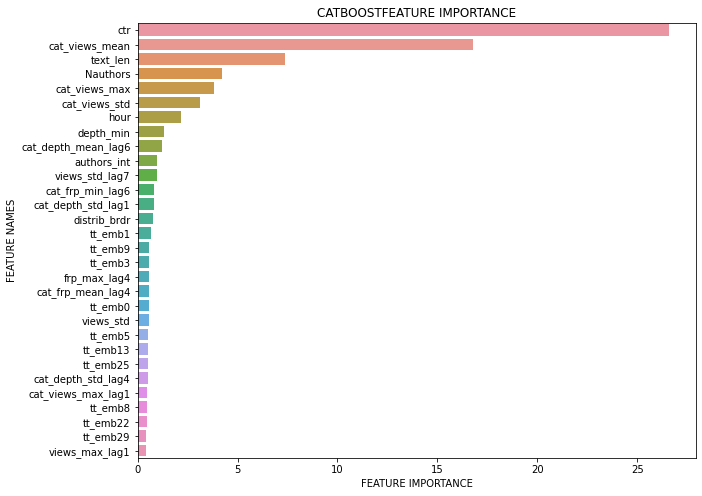

In [25]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_views.get_feature_importance(), train_views_full.get_feature_names(), 'CATBOOST')

## depth

In [26]:
cb_params_depth = cb_params_views

In [27]:
%%time
scores_depth = cv(train_depth_full,
                  cb_params_depth,
                  fold_count=5,
                  seed = CB_RANDOMSEED, 
                  #plot="True"
                 )

Wall time: 2min 10s


In [49]:
if scores_depth['test-RMSE-mean'].argmin() != scores_depth['test-R2-mean'].argmax():
    raise ValueError('wtf?', scores_depth['test-RMSE-mean'].argmin(), scores_depth['test-R2-mean'].argmax())

In [29]:
scores_depth[scores_depth['test-R2-mean'] == scores_depth['test-R2-mean'].max()]
#scores_depth.iloc[scores_depth['test-R2-mean'].argmax()]

,iterations,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
99,99,-0.265,0.019129,-0.192406,0.013376,0.069446,0.002758,0.067472,0.000254


In [30]:
depth_iter =  scores_depth['test-R2-mean'].argmax()
print(depth_iter)

99


In [31]:
cb_model_depth = CatBoostRegressor(iterations=depth_iter,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
                                  )
# Fit model
cb_model_depth.fit(train_depth_full,
                   #plot = True,
                   verbose = 100,
                  )

Learning rate set to 0.319842
0:	learn: 0.0483957	total: 34.7ms	remaining: 3.4s
98:	learn: 0.0153846	total: 3.83s	remaining: 0us


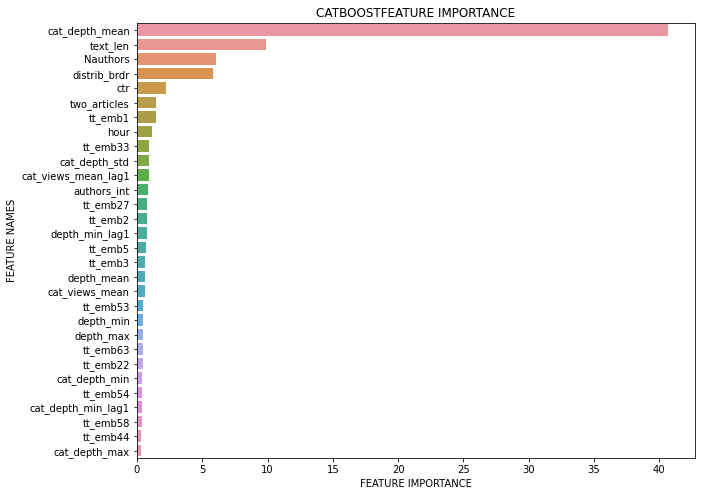

In [32]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_depth.get_feature_importance(), train_depth_full.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [33]:
cb_params_frp = cb_params_views

In [34]:
%%time
scores_frp = cv(train_frp_full,
                  cb_params_frp,
                  fold_count=5,
                  seed = CB_RANDOMSEED, 
                  #plot="True"
                 )

Wall time: 2min 9s


In [36]:
if scores_frp['test-RMSE-mean'].argmin() != scores_frp['test-R2-mean'].argmax():
    raise ValueError('wtf?', scores_frp['test-RMSE-mean'].argmin(), scores_frp['test-R2-mean'].argmax())

In [37]:
scores_frp[scores_frp['test-R2-mean'] == scores_frp['test-R2-mean'].max()]
#scores_frp.iloc[scores_frp['test-R2-mean'].argmax()]

,iterations,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
99,99,0.439756,0.016117,0.469026,0.004297,7.586034,0.232034,7.390794,0.029972


In [38]:
frp_iter = scores_frp['test-R2-mean'].argmax()
print(frp_iter)

99


In [39]:
cb_model_frp = CatBoostRegressor(iterations=frp_iter,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
    #num_trees=None,
                                )
# Fit model
cb_model_frp.fit(train_frp_full,#train_ds_frp,
                   #eval_set=val_ds_frp, 
                   #plot = True,
                 verbose = 100,
                  )

Learning rate set to 0.319842
0:	learn: 8.8570007	total: 46.5ms	remaining: 4.55s
98:	learn: 4.5546316	total: 3.58s	remaining: 0us


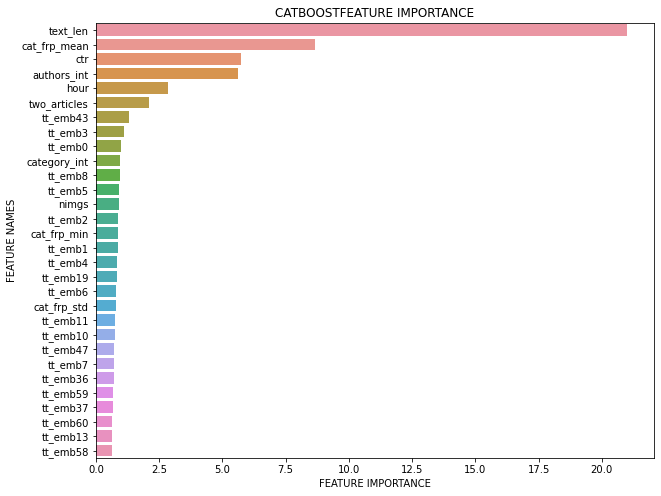

In [40]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_frp.get_feature_importance(), train_frp_full.get_feature_names(), 'CATBOOST')

## Сохраняем предсказания для ансамблей / стекинга

## save models

In [41]:
#cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_pca64_cb_views.cbm'), 
cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NAME}_f.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [42]:
pred_views = cb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = cb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = cb_model_frp.predict(  df_test[cat_cols + num_cols])

In [43]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [44]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,70847.173068,1.043081,16.334374
1440,183803.425967,1.157772,27.326337
2645,178952.300773,1.173345,28.753270


In [45]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [46]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,8829.345132,1.203532,44.385839
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,7193.449355,1.053143,29.157127
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,7671.831280,1.054028,26.555411
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,7479.729690,1.069820,35.746499
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,81776.382712,1.149057,27.070489


In [47]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)